# Workforce Optimization for Professional Service

## Purpose

This tool helps leaders in consulting to forecast future headcount growth. Also, it solves optimized recruits that fills the gap with desirable size of the organization.

## What you have to do

You need to prepare:
1. The current number of headcount in your organization by job title. For example, you need to fill the number of from junior to senior level e.g., Associate, Manager and Partner etc. 
2. Estimated rate of career transition: (1) Promoting to the next level, (2) Staying in the same position and (3) Leaving your organization. The rate should be given by tenure i.e., number of years from the first year.

## Environment setup

In [1]:
import ipywidgets as widgets
from IPython.display import display, Javascript
from ipylab import JupyterFrontEnd

app = JupyterFrontEnd()
def execute_cell(b):
    #display(Javascript('IPython.notebook.execute_cell(1)'))
    #display(Javascript('IPython.notebook.execute_cells_below()'))
    app.commands.execute('notebook:run-all-below')
    

#Install glpk into Jupyter Hub
!conda install -c conda-forge -y glpk





Solving environment: ...working... done

# All requested packages already installed.



In [2]:
button = widgets.Button(description="Initialize")
button.on_click(execute_cell)
display(button)

Button(description='Initialize', style=ButtonStyle())

In [3]:
from pyomo.environ import *
from ipydatagrid import DataGrid,TextRenderer, BarRenderer, VegaExpr
import pandas as pd
import numpy as np
#import matplotlib.pyplot as plt
from matplotlib import *
import ipywidgets as widgets
from IPython.display import display, Javascript


cycle =  [1,2,3,4,5,6,7,8] #4 years cycle
year = [1,2,3,4]
stage = [1,2,3,4,5,6,7]
tran = [1,2,3] #1: stay, 2:promote, 3:drop

stage_name = ['Associate', 
                   'Consultant', 
                   'Senior Consultant', 
                   'Manager', 
                   'Senior Manager',
                   'Associate Partner',
                   'Partner']

stage_dict = dict( zip(stage, stage_name))
stage_dict['8'] =  'Exit'


#Headcount for each cycle
init_fte = [10,8,6,4,2,1,1]
headcnt_list = [ [5,4,3,2,1,1,1],
                 [0,0,0,0,0,0,0],
                 [0,0,0,0,0,0,0],
                 [0,0,0,0,0,0,0],
                 [0,0,0,0,0,0,0],
                 [0,0,0,0,0,0,0],
                 [0,0,0,0,0,0,0],
                 [0,0,0,0,0,0,0],
                 [0,0,0,0,0,0,0],
                 [0,0,0,0,0,0,0],
                 [0,0,0,0,0,0,0]]

#Revenue per month year by title (unit: K$)
revenue = [20, 24, 30, 40, 50, 60, 80]


## Parameters

In [50]:
# Columns
col_top_level = [
    "12","12","12",
    "24","24","24",
    "36","36","36",
    "48","48","48"
]
col_bottom_level = ["FTE", "Stay", "Promote", 
                   "FTE", "Stay", "Promote", 
                   "FTE", "Stay", "Promote", 
                   "FTE", "Stay", "Promote"
                   ]

# Rows
row_top_level = ["Associate", "Consultant", "Senior Consultant", "Manager", "Senior Manager", "Associate Partner", "Partner"]

header_renderer = TextRenderer(
    background_color="moccasin",
    text_color="white",
    vertical_alignment="top",
    horizontal_alignment="center",
)

default_renderer = TextRenderer(
    text_color=VegaExpr("cell.value <= 0 ? 'purple' : 'green'")
)

nested_df = pd.DataFrame(
    np.full((7,12),0),
    columns=pd.MultiIndex.from_arrays([col_top_level, col_bottom_level]),
    index=row_top_level
)


# Set initial values
tran_df = pd.DataFrame([  {"key": "Associate", 
                                               "12-FTE":10,"12-Stay": 0.9, "12-Promote":0.02, 
                                               "24-FTE":0,"24-Stay": 0.59, "24-Promote":0.2,
                                               "36-FTE":0,"36-Stay": 0.65, "36-Promote":0.15,
                                               "48-FTE":0,"48-Stay": 0.65, "48-Promote":0.06
                          },
                              {"key": "Consultant", 
                                               "12-FTE":8,"12-Stay": 0.93, "12-Promote":0.002, 
                                               "24-FTE":0,"24-Stay": 0.78, "24-Promote":0.08,
                                               "36-FTE":0,"36-Stay": 0.78, "36-Promote":0.08,
                                               "48-FTE":0,"48-Stay": 0.89, "48-Promote":0.019
                          },
                              {"key": "Senior Consultant", 
                                               "12-FTE":6,"12-Stay": 0.89, "12-Promote":0.003, 
                                               "24-FTE":0,"24-Stay": 0.83, "24-Promote":0.06,
                                               "36-FTE":0,"36-Stay": 0.85, "36-Promote":0.07,
                                               "48-FTE":0,"48-Stay": 0.95, "48-Promote":0.02
                          },
                              {"key": "Manager", 
                                               "12-FTE":4,"12-Stay": 0.91, "12-Promote":0.0, 
                                               "24-FTE":0,"24-Stay": 0.86, "24-Promote":0.0,
                                               "36-FTE":0,"36-Stay": 0.87, "36-Promote":0.03,
                                               "48-FTE":0,"48-Stay": 0.91, "48-Promote":0.01
                          },
                              {"key": "Senior Manager",
                                               "12-FTE":2,"12-Stay": 0.94, "12-Promote":0.0, 
                                               "24-FTE":0,"24-Stay": 0.85, "24-Promote":0.05,
                                               "36-FTE":0,"36-Stay": 0.8, "36-Promote":0.07,
                                               "48-FTE":0,"48-Stay": 0.93, "48-Promote":0.02
                          },
                              {"key": "Associate Partner",
                                               "12-FTE":1,"12-Stay": 1, "12-Promote":0.0, 
                                               "24-FTE":0,"24-Stay": 0.91, "24-Promote":0.0,
                                               "36-FTE":0,"36-Stay": 0.9, "36-Promote":0.0,
                                               "48-FTE":0,"48-Stay": 0.89, "48-Promote":0.0
                           },
                              {"key": "Partner",
                                               "12-FTE":1,"12-Stay": 0.95, "12-Promote":0.0, 
                                               "24-FTE":0,"24-Stay": 0.94, "24-Promote":0.0,
                                               "36-FTE":0,"36-Stay": 0.82, "36-Promote":0.0,
                                               "48-FTE":0,"48-Stay": 0.85, "48-Promote":0.0
                           }
                           ])


# Copy transition probabiliy into grid

for s in stage:
    for y in year:
        for t in tran:
            #print(f"s={s},y={y},t={t}")
            nested_df.iloc[s-1, 3*(y-1)+t-1] = tran_df.iloc[s-1, 3*(y-1)+t]


nested_df.index.name = 'Title'


text_renderer = TextRenderer(
    text_color="white"
)

tran_grid = DataGrid(
    nested_df,
    base_column_size=100,
    base_column_header_size=35,
    base_row_header_size=80,
    layout={"height": "250px"},
    header_renderer=header_renderer,
    default_renderer=text_renderer,
    editable=True,
    #grid_style = {"column_background_color":"Red"},
    auto_fit_columns=False
)
monokai = {
    "background_color": "#2c292d",
    "grid_line_color": "#a698eb7a",
    "header_background_color": "#2c292d9a",
    "header_grid_line_color": "#fc98675a",
    "selection_fill_color": "#78dce81a",
    "selection_border_color": "#ffd866",
    "header_selection_fill_color": "#ab9df24a",
    "header_selection_border_color": "lawngreen",
    "cursor_fill_color": "#78dce87a",
    "cursor_border_color": "#ff6188"
}

tran_grid.grid_style = monokai

tran_grid.header_renderer = TextRenderer(
    background_color=VegaExpr(
        "cell.column % 2 === 0 ? 'rgb(34, 110, 29)': 'rgb(24, 150, 19)'"
    ),
    text_color="white",
)
tran_grid.renderers = {
    "Title": TextRenderer(
        text_color="white",
    )
}



tran_grid

DataGrid(auto_fit_params={'area': 'all', 'padding': 30, 'numCols': None}, base_column_header_size=35, base_col…

### 

## Execute Optimization

#### Push the button!

In [6]:
def execute_cell(b):
    #display(Javascript('IPython.notebook.execute_cell(1)'))
    #display(Javascript('IPython.notebook.execute_cells_below()'))
    app.commands.execute('notebook:run-all-below')

button = widgets.Button(description="Run Optimization")
button.on_click(execute_cell)
display(button)

Button(description='Run Optimization', style=ButtonStyle())

In [7]:
#Maximum number of hiring for each position per cycle
bond_hire = [ (0,10),
             (0,10),
             (0,10),
             (0,5),
             (0,2),
             (0,1),
             (0,1)
             ]

#Minimum head count ratio (Span of control)
ratio_ast_mng = 2
ratio_con_mng = 2
ratio_sc_mng = 1
ratio_mng_sm = 2
ratio_mng_pt = 2.5
ratio_sm_pt = 2
ratio_sm_ap = 2

### MODEL CONSTRUCTION ###
#Declaration
model = ConcreteModel()

#Decision Variables
model.x = Var(range(70), domain=NonNegativeReals)


revenue = [20, 24, 30, 40, 50, 60, 80]
   

#FTE evolved from itself
fte_from_self = [ 
              [0,0,0,0,0,0,0],
              [0,0,0,0,0,0,0],
              [0,0,0,0,0,0,0],
              [0,0,0,0,0,0,0],
              [0,0,0,0,0,0,0],
              [0,0,0,0,0,0,0],
              [0,0,0,0,0,0,0],
              [0,0,0,0,0,0,0]
                ]


#Calculate evolution of FTE for 5 years
    

for c in cycle:
    
    #derive year number from cycle number
    y_tmp = np.ceil(c/2).astype(int)
    
    for s in stage:
        total_fte = 0
        idx = (c-1)*len(stage) + s -1 #Relative position of hiring parameter
        if c == 1:
            #FTE = tran prob * initial FTE + additional hire
            
            #Staying FTE
            total_fte = total_fte + tran_grid.data.iloc[s-1, 3*(y_tmp-1)+1]*tran_grid.data.iloc[s-1, 3*(y_tmp-1)+0]
                
            #Promoting FTE
            if s > 1:
                total_fte = total_fte + tran_grid.data.iloc[s-2, 3*(y_tmp-1)+2]*tran_grid.data.iloc[s-2, 3*(y_tmp-1)+0]
            
            #New Hire
            total_fte = total_fte + model.x[idx]    
            fte_from_self[c-1][s-1] = total_fte

        else:
            #Staying FTE
            total_fte = total_fte + tran_grid.data.iloc[s-1, 3*(y_tmp-1)+1]*fte_from_self[c-2][s-1]
                
            #Promoting FTE
            if s > 1:
                total_fte = total_fte + tran_grid.data.iloc[s-2, 3*(y_tmp-1)+2]*fte_from_self[c-2][s-2]
            
            
            #New Hire
            total_fte = total_fte + model.x[idx]  
            fte_from_self[c-1][s-1] = total_fte
                             

np.rev = np.array(revenue)

np.fte0 = np.array(init_fte)

#np.fte1 = np.array(fte_from_self[0])
np.fte8 = np.array(fte_from_self[7])

#np.rev1 = np.sum(np.rev*np.fte1)
np.rev0 = np.sum(np.rev*np.fte0)


np.rev8  = np.sum(np.rev*np.fte8)
#growth = (np.rev10-np.rev1)/np.rev1

growth = (np.rev8-np.rev0)/np.rev0
    

            
np.fte = np.array(fte_from_self[1])
            
            

#Objective
#model.profit = Objective(expr=sum(np.fte),
#                     sense=maximize)

model.growth = Objective(expr=growth,
                     sense=maximize)


#model.growth.pprint()


model.fte_ratio = ConstraintList()

#Constraint
for c in cycle:
    
    ast_fte = fte_from_self[c-1][0]
    con_fte = fte_from_self[c-1][1]
    sc_fte = fte_from_self[c-1][2]
    mng_fte = fte_from_self[c-1][3]
    sm_fte = fte_from_self[c-1][4]
    ap_fte = fte_from_self[c-1][5]
    pt_fte = fte_from_self[c-1][6]   
    

    model.fte_ratio.add( expr = ast_fte -1*ratio_ast_mng*mng_fte  >= 0 )
    model.fte_ratio.add( expr = con_fte -1*ratio_con_mng*mng_fte  >= 0 )
    model.fte_ratio.add( expr = sc_fte  -1*ratio_sc_mng*mng_fte  >= 0 )
    model.fte_ratio.add( expr = mng_fte -1*ratio_mng_sm* sm_fte  >= 0 )
    model.fte_ratio.add( expr = mng_fte -1*ratio_mng_pt* pt_fte  >= 0 )
    model.fte_ratio.add( expr = sm_fte  -1*ratio_sm_pt*pt_fte  >= 0 )
    model.fte_ratio.add( expr = sm_fte  -1*ratio_sm_ap*ap_fte  >= 0 )

#Boundary
for c in cycle:
    for s in stage:
        idx = (c-1)*len(stage) + s -1 #Relative position of hiring parameter
        
        lower = 0
        upper =  bond_hire[s-1][1]
        
        model.fte_ratio.add (expr = model.x[idx] <= upper)
       
    
    
#model.fte_ratio.pprint()
    
solver = SolverFactory('glpk')
solver.solve(model)

### OUTPUT ###

# note that we're using f-strings for output here which is a little different and cleaner than in the video
print(f"Maximum Growth = {100*model.growth():,.2f}%")

hiring = np.zeros(56)

for i in range(56):
    hiring[i] = np.round(model.x[i]())
hiring_mtx = np.reshape(hiring, (8,7))
hiring_df = pd.DataFrame(hiring_mtx, columns=stage_name)

#hiring_df.to_csv(out_dir + '/hiring_plan_pyomo.csv', index = True)


#Generate FTE plan

fte_df = pd.DataFrame(columns=[  'cycle', 
                                 'Associate', 
                                 'Consultant', 
                                 'Senior Consultant', 
                                 'Manager',
                                 'Senior Manager',
                                 'Associate Partner',
                                 'Partner'
                                 ],
                      index=range(8))


for c in cycle:
    fte_df.iloc[c-1, 0] =  c
    for s in stage:
       fte_df.iloc[c-1, s]  = fte_from_self[c-1][s-1]()

#fte_df.to_csv(out_dir + '/fte_plan_pyomo.csv', index = False)


Maximum Growth = 472.04%


In [8]:
fte_df

,cycle,Associate,Consultant,Senior Consultant,Manager,Senior Manager,Associate Partner,Partner
0,1,19.0,17.64,15.356,6.430056,2.948709,1.474355,0.95
1,2,27.1,26.7852,23.70212,5.897419,2.948709,1.474355,0.9025
2,3,25.989,36.312456,31.815576,6.493908,2.978197,1.489098,1.489098
3,4,25.33351,43.521516,39.311924,10.470112,3.007979,1.503989,1.503989
4,5,26.466781,47.746809,46.896857,11.860832,3.128298,1.564149,1.564149
5,6,27.203408,51.212528,53.682073,13.601704,4.858463,2.429232,2.282602
6,7,27.682215,57.211354,61.971007,13.841108,5.880423,2.940212,2.940212
7,8,27.99344,62.579038,69.959473,13.99672,6.99836,3.49918,3.49918


In [9]:
hiring_df

,Associate,Consultant,Senior Consultant,Manager,Senior Manager,Associate Partner,Partner
0,10.0,10.0,10.0,3.0,1.0,0.0,0.0
1,10.0,10.0,10.0,0.0,0.0,0.0,0.0
2,10.0,10.0,10.0,0.0,0.0,0.0,1.0
3,10.0,10.0,10.0,3.0,0.0,0.0,0.0
4,10.0,10.0,10.0,0.0,0.0,0.0,0.0
5,10.0,10.0,10.0,0.0,2.0,1.0,1.0
6,10.0,10.0,10.0,0.0,1.0,1.0,1.0
7,10.0,10.0,10.0,0.0,1.0,1.0,1.0


<Axes: xlabel='cycle'>

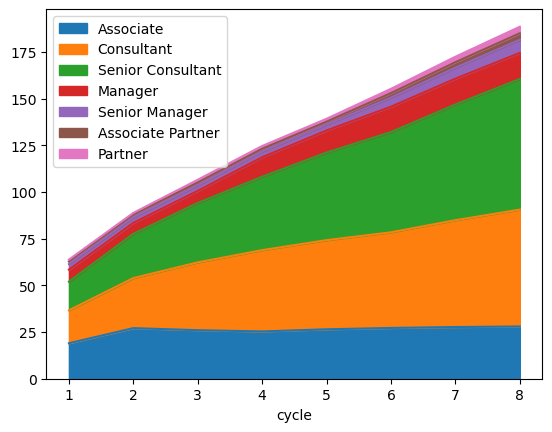

In [10]:
fte_df.plot.area(x='cycle')
